# Final Project Notebook

## Metric: Walkability

For our analysis we decided to take a look at the general quality of life across areas in Pittsburgh, and my corner of that analysis was to assess the amount of pedestrian infrastructure. To do that, I found a dataset that measured the ratio of sidewalks to streets in various blockgroups throughout Pittsburgh. 

If you assume that the goal of making an area "walkable" is at least placing a sidewalk on both sides of any given street, then the ratio to shoot for would be at least 2:1.

One problem with my dataset, however, was that it measured this ratio by GEOIDs, not neighborhoods. So I looked these up to see if I could pull the neighborhood from the GEOIDs it gave me. While there are GEOIDs that can identify zipcodes, the ones I had did not. They identified census blockgroups, and even if they did instead identify zipcodes, I would still need a way to quickly connect zipcode to neighborhood for processing all of the given data. Either way I needed a second spreadsheet to connect the data.

Seeing as my GEOIDs identified census blockgroups, I poked around for a spreadsheet that connected the blockgroups to zipcodes at least, but I found one that directly connected them to their respective neighborhoods, making things much easier for me.

In [120]:
## import all libraries to use

import pandas as pd
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt

## load in spreadsheets to analyze

walk   = pd.read_csv("sidewalkstreetratioupload.csv")
zcodes = pd.read_csv("9756af5f-3320-4601-84e2-347d64071e25.csv")

Then I went ahead and merged both of those dataframes on their GEOID columns.

In [121]:
walkhoodgeo = pd.merge(walk, zcodes, left_on = "GEOID", right_on = "geoid10")

At that point I had a lot of columns of data that I didn't need, so I went and just got rid of them.

In [122]:
walkhoodgeo = walkhoodgeo.loc[:, ["Ratio", "hood", "GEOID"]]

walkhoodgeo = walkhoodgeo.sort_values(by=['hood'])

## View all data in dataframe to check data
## print(hoodwalk.to_string())

At this point I hit a problem; there can be multiple blockgroups in a single neighborhood. Meaning that I had multiple ratio measurements for some neighborhoods that I had to combine into one measurement for the whole neighborhood.

To do this, I made an empty dictionary and a loop. The loop places each neighborhood into the dictionary as a key, and its ratio as its corresponding value. If it hits a duplicate neighborhood, the two ratios are added together and divided by 2 to create the new ratio for both of the blockgroups combined, and it continues until there are no more duplicates and every neighborhood and ratio is entered.

In [132]:
## loop to combine the ratios of neighborhood that contain more than one blockgroup

combDupes={}
for index, row in walkhoodgeo.iterrows():
    hood = row['hood']
    if hood in combDupes:
        combDupes[hood] = (combDupes[hood] + row['Ratio']) / 2
    else:
        combDupes[hood] = row['Ratio']
    

## display resulting dictionary to check data
## combDupes

Then I crammed the resulting dictionary into a new dataframe.

In [124]:
## create dataframe and fill it with the combDupes dictionary

walkhood = pd.DataFrame(combDupes.items())
walkhood.columns = ['Neighborhood', 'Ratio']

## display dataframe to check data
## print(walkhood.to_string())

Then to help visualize the results, I loaded up the shape file of the City of Pittsburgh from the data visualization lab.

In [125]:
## load up shape file to map the data

neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

## make sure the map loads properly
## neighborhoods.plot()

Next up I merged the neighborhood map data with my data.

In [126]:
## merge neighborhood shape file with walkability ratio data

walkmap = neighborhoods.merge(walkhood, how='left', left_on='hood', right_on='Neighborhood')

## check for successful merge
## walkmap[['Neighborhood','Ratio','geometry']].head()

Then we finally get to plot the results on a map of Pittsburgh

(yes this was just copypasted from the data visualizaton lab, ain't broke don't fix it etc.)

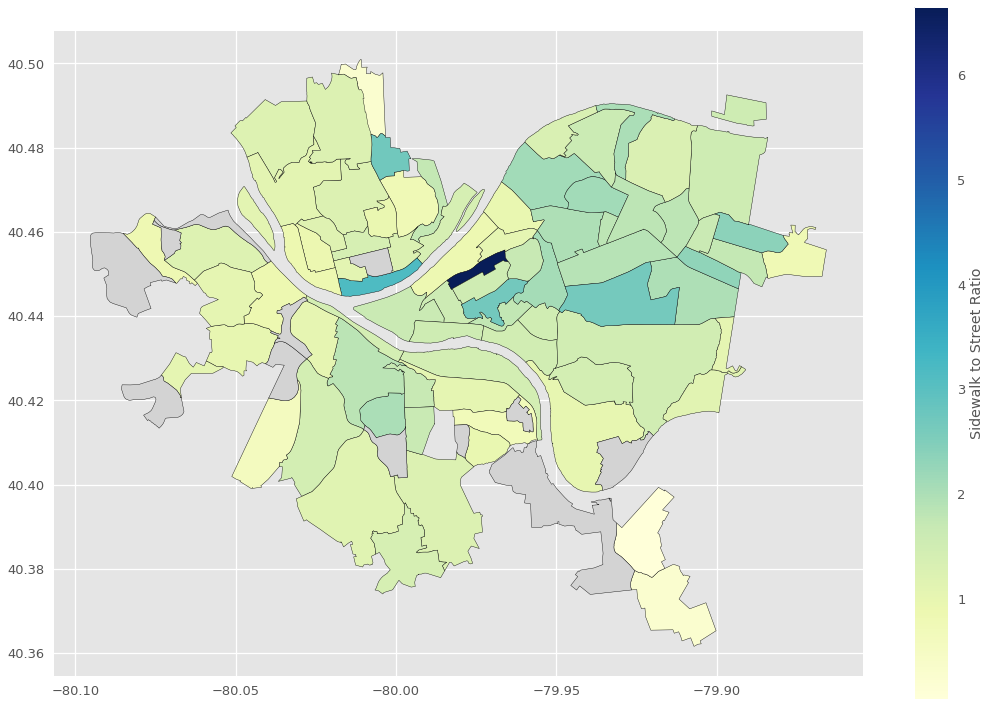

In [127]:
walkmap.plot(column='Ratio',
               cmap='YlGnBu',
               edgecolor="black", 
               legend=True,
               legend_kwds={'label': "Sidewalk to Street Ratio"},
               figsize=(15, 10),
               missing_kwds={"color": "lightgrey"}
               )

And while a heatmap is useful for a quick visual understanding, this doesn't declare the neighborhoods by name, so I bargraphed the results as well.

Text(0, 0.5, 'Sidewalk to Street Ratio')

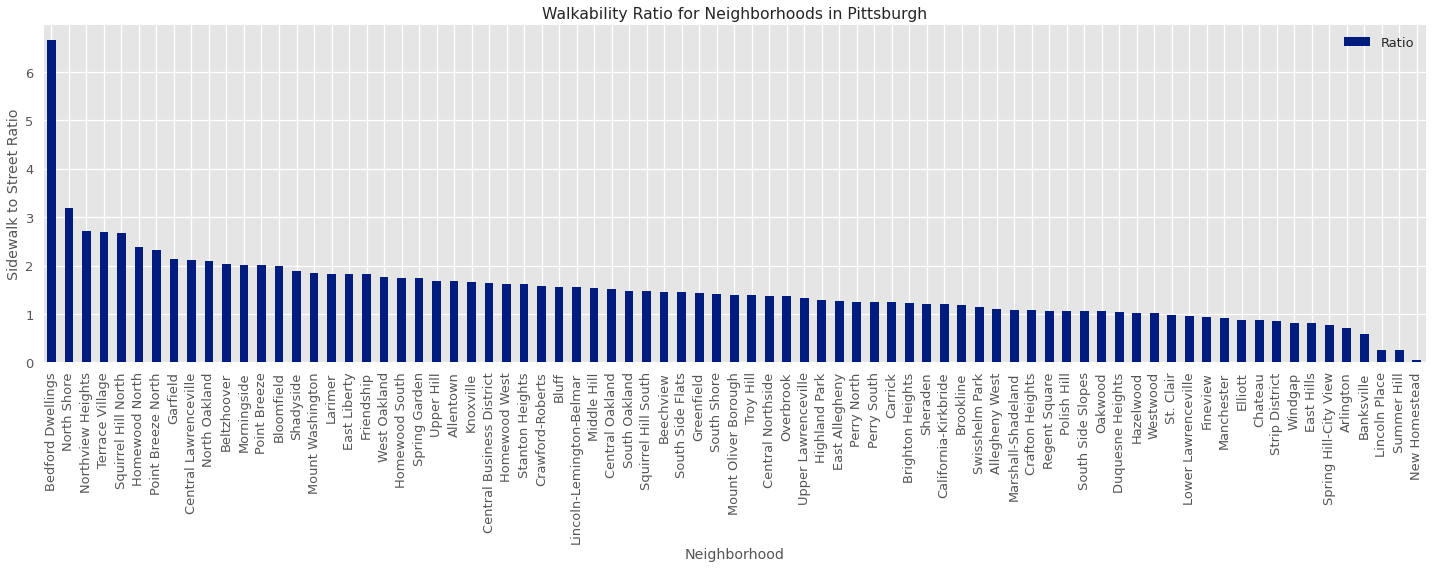

In [128]:
## plot the data with a bargraph
## plus visual formatting and sorting

walkhood.sort_values(by=['Ratio'], inplace=True, ascending=False)
plt.rcParams['figure.figsize'] = [20, 8]
plt.style.use('seaborn-dark-palette')
walkhood.plot.bar(x="Neighborhood", y="Ratio")
plt.title("Walkability Ratio for Neighborhoods in Pittsburgh")
plt.xlabel("Neighborhood")
plt.ylabel("Sidewalk to Street Ratio")

Then we'll zoom in on the top 10 for an easier comparison.

Text(0, 0.5, 'Sidewalk to Street Ratio')

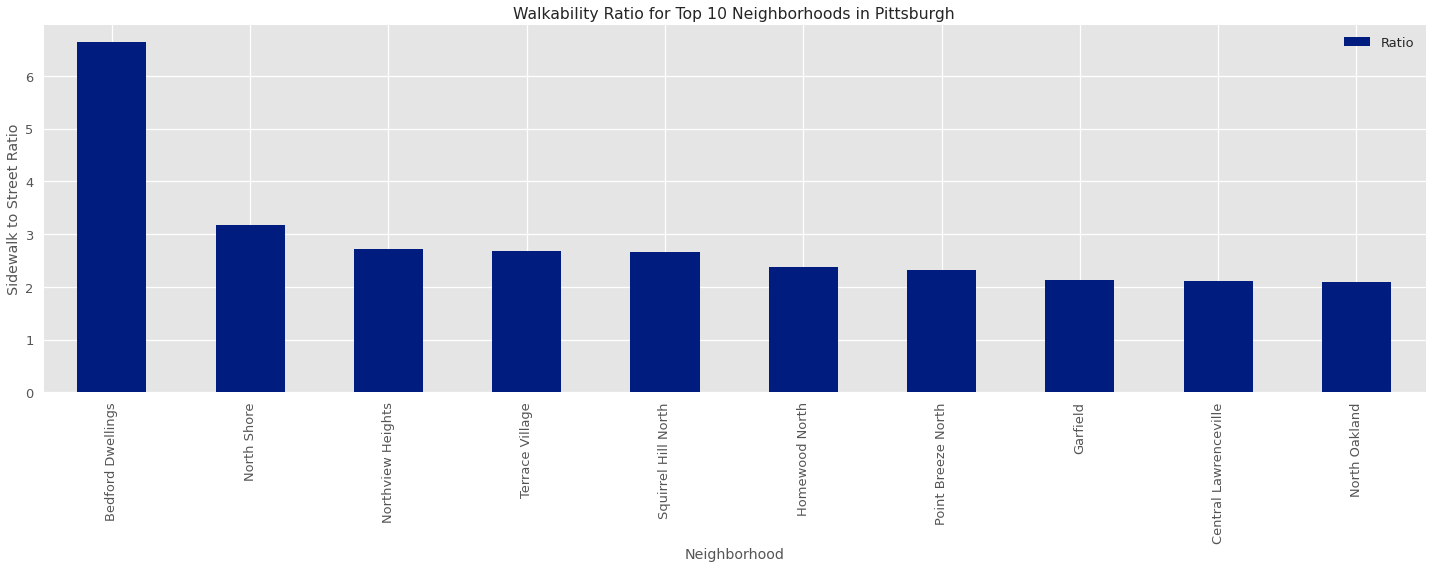

In [129]:
walkhood.head(10).plot.bar(x="Neighborhood", y="Ratio")
plt.title("Walkability Ratio for Top 10 Neighborhoods in Pittsburgh")
plt.xlabel("Neighborhood")
plt.ylabel("Sidewalk to Street Ratio")

# Conclusion

At this point, we can clearly conclude that Bedford Dwellings has by far the highest sidewalk-to-street ratio. This jump was so extreme that I thought it might've been some odd outlier caused by some of my processing, but when I went back to check the spreadsheet itself, this is a lone datapoint for a single blockgroup, so it is what it is.

(Side comment, I thought it was interesting how many of the top neighborhoods had "north" in their name. Maybe a coincidence, maybe there's a greater implication to explore by analyzing some other data collections? Who knows.)

Clearly simplying measuring how much sidewalk compared to street exists in a given neighborhood isn't a perfect indicator of walkability or pedestrian quality of life. To get a better overall picture you might want to also take a look at public transit infrastructure as well, but that's outside of the scope of this project.

For now though, if you really wanna be able to brag about living in the neighborhood with the highest sidewalk-to-street ratio, check out Bedford Dwellings.